In [1]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import wall_growth_kit as walkit
import seaborn as sns
import math

%load_ext autoreload
%autoreload 2

This part includes the theory for the pressure-biomass model where mass increases in lockstep with cell surface area.

We will allow the radius to vary, with the layer number $n$ at which we see a change in stiffness dependent on the initial radius as $n=r_0*\epsilon^*/\Delta r$, where $\epsilon^*=0.02$. Furthermore, we can implement a pressure-biomass-density relation simply by forcing the steady state pressure to vary inversely with $r^2$.

In [127]:
pressure,num_layers=1.0,20.0
alpha1, alpha2, poisson_ratio=2.0, 0.1, 0.1
strain_cutoff=0.02  # note we are now specifying the cell starting radius, since otherwise we cannot solve for
# the steady state so readily. Here, n_cutoff-1 specifies how many layers in you need to go in order

turnover_rate=1.0
PK_rat=0.5
wall_thickness=0.03
num_layers=20
params={'P':pressure,'alpha1':alpha1,'alpha2':alpha2,'K':pressure/PK_rat,'nu':poisson_ratio, 'dt':1.0/turnover_rate,
        'dr':wall_thickness/(num_layers-1), 'N':num_layers, 'PK_rat':PK_rat,'strain_cutoff':strain_cutoff} 
# note we no longer define dt here.

In [128]:
def sum_3(temp_vals,temp_params):
    # Here, we calculate the LHS of the radial stress constraint, given a fixed radius r, and a sum limit given
    # by temp_vals[2]. Temp_vals[0] is the growth rate, temp_vals[1] is the inner radius, temp_vals[2] is
    # the sum limit, temp_vals[3] is the alpha value for this summation.
    temp_nu=temp_params['nu']
    temp_dr=temp_params['dr']
    temp_k=temp_params['K']
    temp_dt=temp_params['dt']
    # parameters that are varied to solve matters. Note that this is just the growth rate, since
    # growth rate and timestep are not linearly independent.
    temp_gfact = temp_vals[0]*temp_dt
    temp_r=temp_vals[1]
    # parameters that are specific to this sum
    temp_n, temp_a=temp_vals[2], temp_vals[3] # note that alpha must be set externally
    #
    temp_x=np.exp(temp_gfact) # exponential growth rate factor for each turnover event.
    #
#     temp_1=(temp_k*temp_dr/(temp_a-temp_nu**2))*(temp_nu*(temp_x**(temp_n+1)-temp_x)/(temp_x-1)-temp_nu*(temp_n)+temp_dr*temp_n*(temp_n+1)/(2*temp_r))
    temp_1=((temp_k*temp_dr)/(temp_a-temp_nu**2))*(temp_nu*(temp_x**(temp_n+1)-temp_x)/(temp_x-1)-temp_nu*(temp_n)+temp_dr*temp_n*(temp_n+1)/(2*temp_r))
    return temp_1


def sum_4(temp_vals,temp_params):
    # Here, we calculate the LHS of the longitudinal stress constraint, given a fixed radius r, and a sum limit given
    # by temp_vals[2]. Temp_vals[0] is the growth rate, temp_vals[1] is the inner radius, temp_vals[2] is
    # the sum limit, temp_vals[3] is the alpha value for this summation.
    temp_nu=temp_params['nu']
    temp_dr=temp_params['dr']
    temp_k=temp_params['K']
    temp_dt=temp_params['dt']
    # parameters that are varied to solve matters. Note that this is just the growth rate, since
    # growth rate and timestep are not linearly independent.
    temp_gfact = temp_vals[0]*temp_dt
    temp_r=temp_vals[1]
    # parameters that are specific to this sum
    temp_n, temp_a=temp_vals[2], temp_vals[3] # note that alpha must be set externally
    #
    temp_x=np.exp(temp_gfact) # exponential growth rate factor for each turnover event.
    #
    temp_1=((temp_k*temp_dr)/(temp_a-temp_nu**2))*(temp_r*temp_a*((temp_x**(temp_n+1)-temp_x)/(temp_x-1)-temp_n)+temp_nu*temp_dr*temp_n*(temp_n+1)/2 \
        +temp_dr*temp_a*(((temp_n+1)*temp_x**(temp_n+2)-(temp_n+2)*temp_x**(temp_n+1)+1)/(temp_x-1)**2-1-temp_n*(temp_n+1)/2) \
        +temp_nu*temp_dr**2*temp_n*(temp_n+1)*(2*temp_n+1)/(temp_r*6))
    return temp_1
    
    
def min_eq_v2(temp_vals,temp_params):
    # We aim to find the roots of this equation in order to determine the possible growth and radii
    # at steady state.
    temp_sum_lim=temp_params['N']-1  # number of layers - 1
    
    temp_r=temp_vals[1]
    temp_n_cutoff=np.floor(temp_params['strain_cutoff']*temp_r/temp_params['dr'])

    
    # This is for the strain-stiffening model
    temp_vals1=list(temp_vals)+list([temp_n_cutoff, temp_params['alpha1']])  # this is the innermost sum
    temp_vals2=list(temp_vals)+list([temp_sum_lim, temp_params['alpha2']])  # this is the outermost sum
    temp_vals3=list(temp_vals)+list([temp_n_cutoff, temp_params['alpha2']])  # this is the difference sum 
#     print(temp_vals1, temp_vals2, temp_vals3)
    # defining terms here
    temp_dr=temp_params['dr']
    temp_p=temp_params['P']
    temp_k=temp_params['K']
    # pressure rhs terms for radial and longitudinal constraints respectively
    temp_p1=2*np.absolute((temp_r+temp_dr)*temp_p*temp_r/(temp_r+temp_dr)**2) # radial constraint
    temp_p2=2*np.absolute(((temp_r+temp_dr)**2)*temp_p*temp_r/(2*(temp_r+temp_dr)**2))  # longitudinal constraint
    # Here we break the summations into their respective parts for the different alpha values. Note that this
    # is possible because the different layers sum linearly.
    # Strain-stiffening model
#     temp1=sum_3(temp_vals1,temp_params)+sum_3(temp_vals2,temp_params)-sum_3(temp_vals3,temp_params)-temp_p1
#     temp2=sum_4(temp_vals1,temp_params)+sum_4(temp_vals2,temp_params)-sum_4(temp_vals3,temp_params)-temp_p2
    # non-stiffening model
    temp1=sum_3(temp_vals2,temp_params)-temp_p1
    temp2=sum_4(temp_vals2,temp_params)-temp_p2
#     print(temp_p1, temp_p2)
    return [temp1,temp2]

In [129]:
r_vals,gr_vals=np.linspace(0.01,1.0,100), np.linspace(0.001,0.1,100)

for ind1 in range(len(r_vals)):
    for ind2 in range(len(gr_vals)):
        init=[gr_vals[ind2],r_vals[ind1]]
        sol = optimize.root(min_eq_v2, init, args=(params),method='hybr')
        if sol.success:
            break
    if sol.success:
        break

In [130]:
print(sol.x)

[0.07294054 0.00682859]


In [131]:
sol.success

True

In [132]:
print('gr, radius', sol.x)
print('cutoff_layer', math.ceil(params['strain_cutoff']*sol.x[1]/params['dr']))

gr, radius [0.07294054 0.00682859]
cutoff_layer 1


In [133]:
min_eq_v2(sol.x,params)

[-1.1102230246251565e-15, -1.9081958235744878e-17]

Okay, so at least we are getting stable growth outside of the fingertrap regime. However, as we see below, these parameters do not lead to stable growth within our simulations.

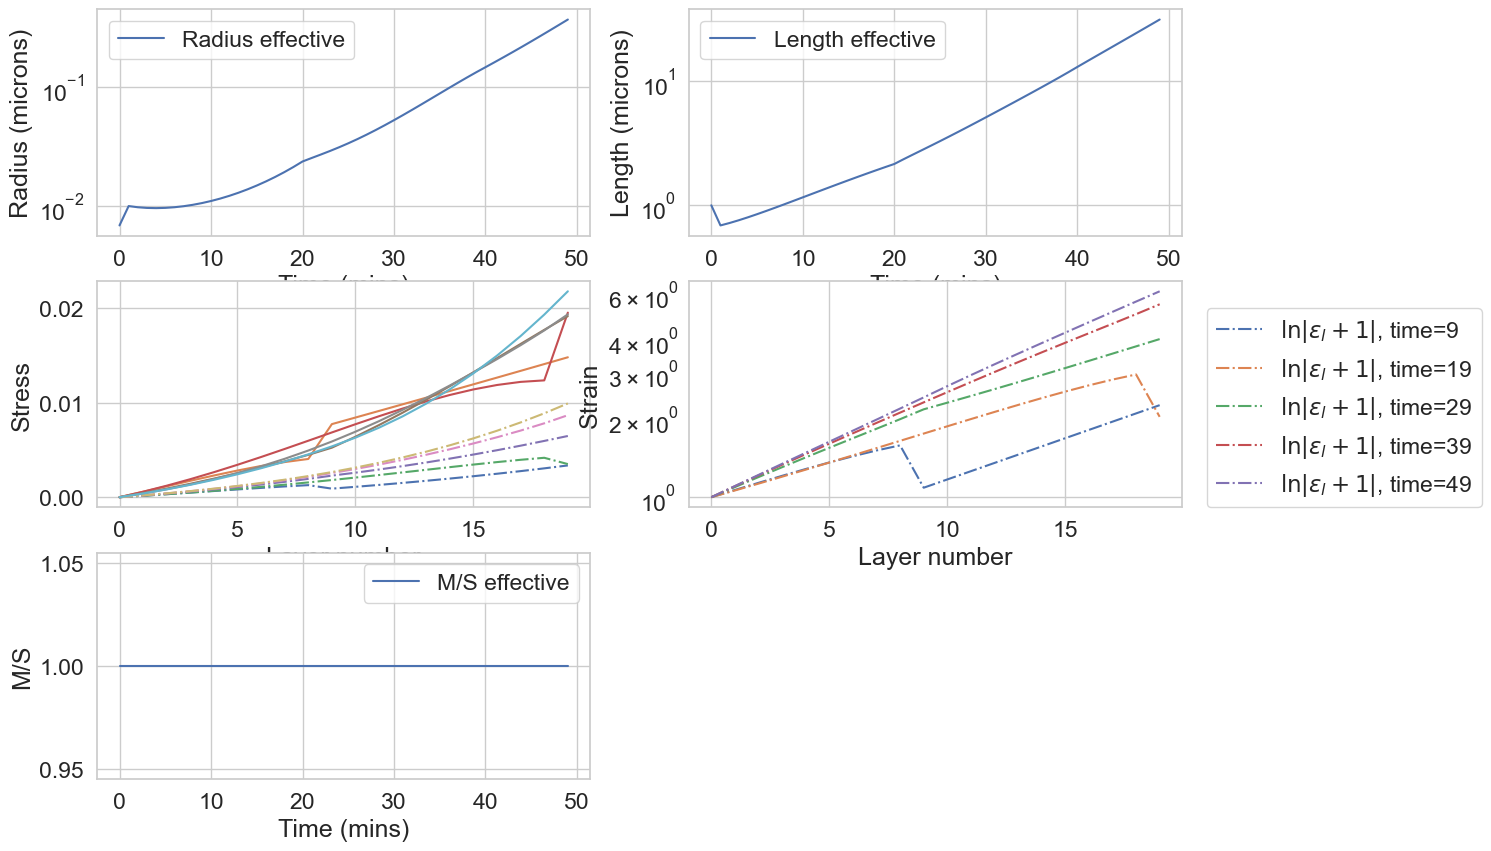

Growth rate (per min) = 0.05509
Doubling time  (mins) = 12.5829
Average cell radius = 0.01229
Theory growth rate and radius = [0.07294054 0.00682859]


<Figure size 640x480 with 0 Axes>

In [136]:
pressure,num_layers=1.0,20.0
alpha1, alpha2, poisson_ratio=0.5001, 0.5001, 0.1
strain_cutoff=0.02  # note we are now specifying the cell starting radius, since otherwise we cannot solve for
# the steady state so readily. Here, n_cutoff-1 specifies how many layers in you need to go in order
# We are now also specifying the starting biomass as the steady state value (i.e. the synthesis rate times the 
# surface area). Note that for contrast with the analytics above, we should set the same PK_rat, and have the 
# biomass synthesis rate set to 1.0.

turnover_rate=1.0
PK_rat=0.1
wall_thickness=0.03
num_layers=20
params={'P':pressure,'alpha1':alpha1,'alpha2':alpha2,'K':pressure/PK_rat,'nu':poisson_ratio, 'dt':1.0/turnover_rate,
        'dr':wall_thickness/(num_layers-1), 'N':num_layers, 'PK_rat':PK_rat,'strain_cutoff':strain_cutoff, 'k_rate':1.0} 
# note we no longer define dt here.

numstep=50
tvec=np.arange(numstep)
ri,li=sol.x[1]*np.ones(int(num_layers)),1.0*np.exp(-sol.x[0]*np.arange(0,int(num_layers)).astype(float)*params['dt'])
mi = params['k_rate']*2.0*math.pi*ri[0]*li[0]

radii,lengths,eff_rad,eff_length,eff_mass=walkit.sim_growth_biomass_strain_stiffening(tvec,ri,li,mi,params)

rad_vals=np.asarray([temp[0] for temp in radii if len(temp)>0])
l_vals=np.asarray([temp[0] for temp in lengths if len(temp)>0])
stiffnesses=np.ones(ri.shape)

dr=wall_thickness/num_layers
sns.set(font_scale=1.5,style='whitegrid')
fig=plt.figure(figsize=[14,10])
plt.subplot(3,2,1)
# plt.semilogy(tvec[1:len(rad_vals)-1],rad_vals[1:len(rad_vals)-1],label='Radius')
plt.semilogy(tvec,eff_rad,label='Radius effective')
plt.legend()
plt.xlabel('Time (mins)')
plt.ylabel('Radius (microns)')
plt.subplot(3,2,2)
# plt.semilogy(tvec[1:len(rad_vals)-1],l_vals[1:len(l_vals)-1],label='Length')
plt.semilogy(tvec,eff_length,label='Length effective')
plt.legend()
plt.xlabel('Time (mins)')
plt.ylabel('Length (microns)')
plt.subplot(3,2,3)
nu=np.copy(poisson_ratio)
for ind in np.arange(len(tvec)/5-1,len(tvec),len(tvec)/5):
    ind1=ind.astype(int)
    temp_rval,temp_lval=radii[ind1][0],lengths[ind1][0]
    temp_ri,temp_li,temp_si=radii[ind1],lengths[ind1],stiffnesses
    
    eps_r = (temp_rval+dr*np.arange(0,len(temp_ri)).astype(float)-temp_ri)/temp_ri # radial strain in each layer 
    # based on equal spacing between layers of dr.
    eps_l = (temp_lval-temp_li)/temp_li # longitudinal strain in each layer
    # Now we calculate the tensions in each layer
    alphas = alpha1 * (eps_r < strain_cutoff) + alpha2 * (
            eps_r >= strain_cutoff)  # this gives the
    # specific values for alpha for each layer in this configuration. Note that this is a vector.
    
    sig_l = dr*temp_si*((alphas/(alphas-nu**2))*eps_l+(nu/(alphas-nu**2))*eps_r) # the longitudinal tension in each layer 
    sig_r = dr*temp_si*((nu/(alphas-nu**2))*eps_l+(1/(alphas-nu**2))*eps_r) # the radial tension in each layer 
    plt.plot(sig_l,label=r'$\lambda_l/K_0$, time={}'.format(np.around(tvec[ind1],2)),linestyle='-.')
    plt.plot(sig_r,label=r'$\lambda_r/K_0$, time={}'.format(np.around(tvec[ind1],2)),linestyle='-')
plt.xlabel('Layer number')
plt.ylabel('Stress')

plt.subplot(3,2,4)
nu=np.copy(poisson_ratio)
for ind in np.arange(len(tvec)/5-1,len(tvec),len(tvec)/5):
    ind1=ind.astype(int)
    temp_rval,temp_lval=radii[ind1][0],lengths[ind1][0]
    temp_ri,temp_li,temp_si=radii[ind1],lengths[ind1],stiffnesses
    
    eps_r = (temp_rval+dr*np.arange(0,len(temp_ri)).astype(float)-temp_ri)/temp_ri # radial strain in each layer 
    # based on equal spacing between layers of dr.
    eps_l = (temp_lval-temp_li)/temp_li # longitudinal strain in each layer
    plt.semilogy(eps_l+1,label=r'$\ln|\epsilon_l+1|$, time={}'.format(np.around(tvec[ind1],2)),linestyle='-.')
#     plt.plot(eps_r,label=r'$\epsilon_r$, time={}'.format(np.around(tvec[ind1],2)),linestyle='-')
plt.xlabel('Layer number')
plt.ylabel('Strain')
plt.legend(loc=[1.05,0.0])
plt.subplot(3,2,5)
plt.plot(tvec,eff_mass/(2*math.pi*eff_rad*eff_length),label='M/S effective')
plt.legend()
plt.xlabel('Time (mins)')
plt.ylabel('M/S')


plt.show()

plt.clf()

cutoff=np.nonzero(tvec>2*np.log(2)/sol.x[0])[0][0]
out=scipy.stats.linregress(tvec[:cutoff],np.log(eff_length[:cutoff]))
print("Growth rate (per min) = {0}".format(np.around(out.slope,5)))
print("Doubling time  (mins) = {0}".format(np.around(np.log(2)/out.slope,4)))
print("Average cell radius = {0}".format(np.around(np.nanmean(eff_rad[:cutoff]),5)))
print("Theory growth rate and radius =", sol.x)

This part shows some phase space predictions from the modeling approach.

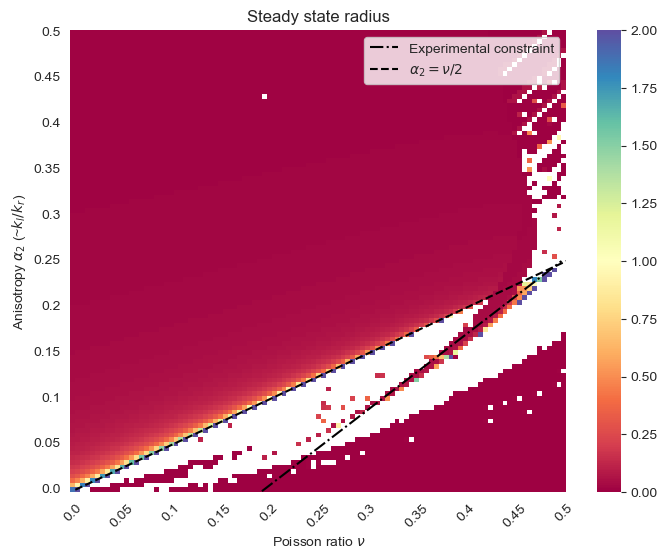

<Figure size 640x480 with 0 Axes>

In [224]:
temp_y=alphas[::-1].copy()
temp_x=nus.copy()

fig=plt.figure(figsize=[8,6])
ax=plt.subplot(1,1,1)

yticks = temp_y
keptticks = np.around(yticks[::int(len(yticks)/10)],2)
yticks = ['' for y in yticks]
yticks[::int(len(yticks)/10)] = keptticks

xticks = temp_x
keptticks = np.around(xticks[::int(len(xticks)/10)],2)
xticks = ['' for y in xticks]
xticks[::int(len(xticks)/10)] = keptticks
sns.set_style('whitegrid')
sns.heatmap(sol_rad[::-1,:]*(sol_rad[::-1,:]>0),xticklabels=xticks,yticklabels=yticks,cmap='Spectral',vmin=0,vmax=2)
ax=plt.gca()

rat=(-4.8669*10**(-5))/(1.5809*10**(-5))
yv=constraint_plot(nus,rat)
ind=np.nonzero(yv>0)[0][0]
# plt.plot(xv,yv,label='Constraint')
temp_xv=np.arange(ind,len(nus))
temp_yv=len(alphas)-yv[ind:]*len(alphas)/np.amax(alphas)
plt.plot(temp_xv,temp_yv,label='Experimental constraint',color='k',linestyle='-.')


temp_xv=np.arange(1,len(nus)+1)
yv=0.5*temp_x
temp_yv=len(alphas)*(1-yv/np.amax(alphas))
plt.plot(temp_xv,temp_yv,label=r'$\alpha_2=\nu/2$',color='k',linestyle='--')
plt.legend()
plt.xticks(rotation = 45)
plt.yticks(rotation = .001)
plt.xlabel(r'Poisson ratio $\nu$')
plt.ylabel(r'Anisotropy $\alpha_2$ (~$ k_l/k_r$)')
plt.title('Steady state radius')
plt.show()



# fig.savefig('./quality_figs/sven_surface_gr_steady_state_radius_model.png',dpi=300,bbox_inches='tight')
# fig.savefig('./quality_figs/strain_stiffening_steady_state_radius_model.png',dpi=300,bbox_inches='tight')
plt.clf()

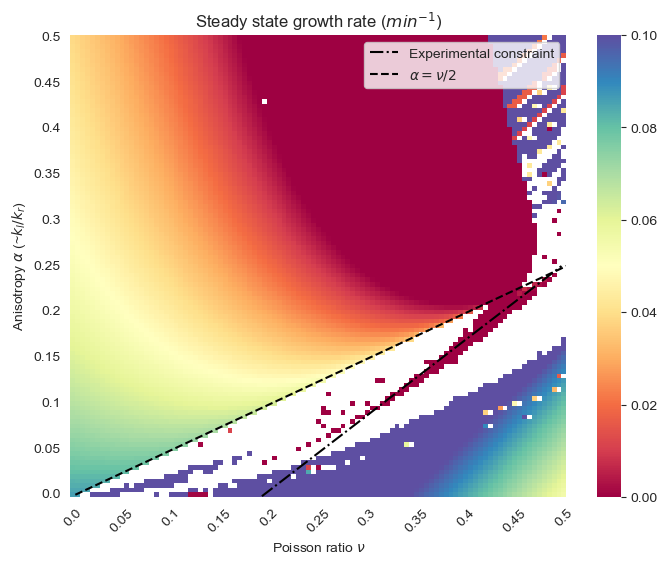

<Figure size 640x480 with 0 Axes>

In [219]:
temp_y=alphas[::-1].copy()
temp_x=nus.copy()

yticks = temp_y
keptticks = np.around(yticks[::int(len(yticks)/10)],2)
yticks = ['' for y in yticks]
yticks[::int(len(yticks)/10)] = keptticks

xticks = temp_x
keptticks = np.around(xticks[::int(len(xticks)/10)],2)
xticks = ['' for y in xticks]
xticks[::int(len(xticks)/10)] = keptticks
fig=plt.figure(figsize=[8,6])
ax=plt.subplot(1,1,1)
sns.heatmap(sol_gr[::-1,:],xticklabels=xticks,yticklabels=yticks,cmap='Spectral',vmin=0.0,vmax=0.1)
# sns.heatmap(sol_gr[::-1,:],xticklabels=xticks,yticklabels=yticks,cmap='Spectral',vmax=0.1)

rat=(-4.8669*10**(-5))/(1.5809*10**(-5))
yv=constraint_plot(nus,rat)
ind=np.nonzero(yv>0)[0][0]
# plt.plot(xv,yv,label='Constraint')
temp_xv=np.arange(ind,len(nus))
temp_yv=len(alphas)-yv[ind:]*len(alphas)/np.amax(alphas)
plt.plot(temp_xv,temp_yv,label='Experimental constraint',color='k',linestyle='-.')

yv=0.5*temp_x
temp_xv=np.arange(1,len(nus)+1)
temp_yv=len(alphas)*(1-yv/np.amax(alphas))
plt.plot(temp_xv,temp_yv,label=r'$\alpha=\nu/2$',color='k',linestyle='--')
rat

ax=plt.gca()
plt.xticks(rotation = 45)
plt.yticks(rotation = .001)
plt.xlabel(r'Poisson ratio $\nu$')
plt.ylabel(r'Anisotropy $\alpha$ (~$ k_l/k_r$)')
plt.title('Steady state growth rate ($min^{-1}$)')
plt.legend()

plt.show()
# fig.savefig('./quality_figs/sven_surface_gr_steady_state_gr_model.png',dpi=300,bbox_inches='tight')
# fig.savefig('./quality_figs/steady_state_gr_model_unfiltered.png',dpi=300,bbox_inches='tight')
plt.clf()

This figure shows the region in which both steady state radius and growth rate are positive within the model.

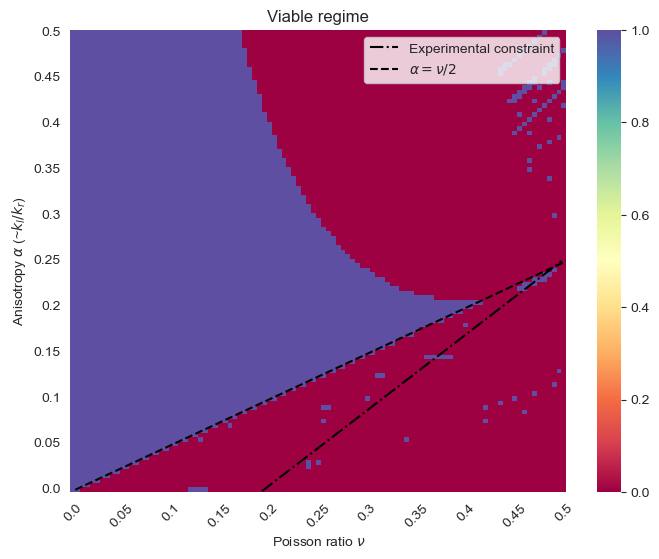

<Figure size 640x480 with 0 Axes>

In [232]:
temp_y=alphas[::-1].copy()
temp_x=nus.copy()

fig=plt.figure(figsize=[8,6])
ax=plt.subplot(1,1,1)

yticks = temp_y
keptticks = np.around(yticks[::int(len(yticks)/10)],2)
yticks = ['' for y in yticks]
yticks[::int(len(yticks)/10)] = keptticks

xticks = temp_x
keptticks = np.around(xticks[::int(len(xticks)/10)],2)
xticks = ['' for y in xticks]
xticks[::int(len(xticks)/10)] = keptticks
sns.set_style('whitegrid')
sns.heatmap((sol_gr[::-1,:]>0)*(sol_rad[::-1,:]>0),xticklabels=xticks,yticklabels=yticks,cmap='Spectral',vmin=0,vmax=1)
ax=plt.gca()

rat=(-4.8669*10**(-5))/(1.5809*10**(-5))
yv=constraint_plot(nus,rat)
ind=np.nonzero(yv>0)[0][0]
# plt.plot(xv,yv,label='Constraint')
temp_xv=np.arange(ind,len(nus))
temp_yv=len(alphas)-yv[ind:]*len(alphas)/np.amax(alphas)
plt.plot(temp_xv,temp_yv,label='Experimental constraint',color='k',linestyle='-.')


temp_xv=np.arange(1,len(nus)+1)
yv=0.5*temp_x
temp_yv=len(alphas)*(1-yv/np.amax(alphas))
plt.plot(temp_xv,temp_yv,label=r'$\alpha=\nu/2$',color='k',linestyle='--')
plt.legend()
plt.xticks(rotation = 45)
plt.yticks(rotation = .001)
plt.xlabel(r'Poisson ratio $\nu$')
plt.ylabel(r'Anisotropy $\alpha$ (~$ k_l/k_r$)')
plt.title('Viable regime')
plt.show()



# fig.savefig('./quality_figs/sven_surface_gr_steady_state_radius_model.png',dpi=300,bbox_inches='tight')
# fig.savefig('./quality_figs/strain_stiffening_steady_state_radius_model.png',dpi=300,bbox_inches='tight')
plt.clf()

Okay, so for this model we still observe that there is only one region of phase space in which we can get viable, steady state growth. There is no continuous region of stable growth in the fingertrap regime.